In [2]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

path_src = "/local/scratch/Figaro/figaro-code"
exp_names = ["figaro", "mkl"]
exp_paths = {"figaro": "comparisons/performance/lapack", "mkl": "comparisons/performance/python/mkl"}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"

df_measurement_exps = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(path_src, exp_path)
    df_measurement = pd.DataFrame(columns=db_names)

    for db_name in db_names:
        #gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        #print(gather_times_path)
        #out_workbook = Workbook()
        #out_workbook.remove(out_workbook.active)
        #out_sheet = out_workbook.create_sheet("Times")

        for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
            db_name_per = "{}PK1C{}".format(db_name, percent)
            path_xlsx = os.path.join(perf_path, db_name_per, xlsx_name)
            workbook = load_workbook(filename=path_xlsx, data_only=True)
            sheet = workbook.active
            row_count = sheet.max_row
            col_idx = db_idx + 1
            col_letter = get_column_letter(col_idx)
            
            #out_sheet.cell(row=1, column=col_idx).value = db_name_per
            
            start_row_idx = 2
            np_measures = np.zeros(num_measurement)
            for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                offset_idx = row_idx_dst - start_row_idx
                row_idx_src = row_count - num_measurement  + offset_idx
                val = sheet.cell(row=row_idx_src, column=2).value
                np_measures[offset_idx] = float(val)
                #print(idx_shift, db_idx)
                #out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
            
            #out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
            #        col_letter,6)

            time_avg = np.mean(np_measures[1:])
            df_measurement.at[percent, db_name] = time_avg
            
        #out_workbook.save(gather_times_path)
        print(df_measurement)
        df_measurement.index = df_measurement.index.set_names(['index'])
        df_measurement = df_measurement.astype(float)
    df_measurement_exps[exp_name] = df_measurement





    DBRetailer DBFavorita DBYelp
10     7.68313        NaN    NaN
20     14.9234        NaN    NaN
30      25.209        NaN    NaN
40     37.6382        NaN    NaN
50     44.7474        NaN    NaN
60     54.9099        NaN    NaN
70     74.1823        NaN    NaN
80     89.5607        NaN    NaN
90     105.243        NaN    NaN
100    120.222        NaN    NaN
       DBRetailer  DBFavorita  DBYelp
index                                
10       7.683128    7.582792     NaN
20      14.923366   23.680546     NaN
30      25.208987   26.686610     NaN
40      37.638193   37.687311     NaN
50      44.747427   50.709238     NaN
60      54.909946   70.649625     NaN
70      74.182320   85.949107     NaN
80      89.560681  104.174460     NaN
90     105.242818  120.931254     NaN
100    120.222099  157.797358     NaN
       DBRetailer  DBFavorita    DBYelp
index                                  
10       7.683128    7.582792  0.165662
20      14.923366   23.680546  0.186014
30      25.208987   2

In [ ]:
import csv

db_name_map = {
    "DBFavorita": "exp1perf-favorita.dat", 
    "DBRetailer": "exp1perf-retailer.dat", 
    "DBYelp": "exp1perf-yelp.dat"
    }
exp_dat_names = ["#percentage of data", "figaro-time", "mkl-time"]

for db_name in db_names:
    dbs_results = []
    for exp_name in exp_names:
        dbs_results.append(df_measurement_exps[exp_name][db_name])
    df_db_results = pd.concat(dbs_results, axis=1)
    df_db_results = df_db_results.reset_index().rename(columns={df_db_results.index.name:'index'})
    df_db_results.columns = exp_dat_names
    df_db_results.to_csv(db_name_map[db_name], float_format='%.2f', sep='\t', index=False, quoting=csv.QUOTE_NONE,  escapechar=" ")

{'figaro':        DBRetailer  DBFavorita    DBYelp
index                                  
10       7.683128    7.582792  0.165662
20      14.923366   23.680546  0.186014
30      25.208987   26.686610  0.215623
40      37.638193   37.687311  0.226403
50      44.747427   50.709238  0.249574
60      54.909946   70.649625  0.256850
70      74.182320   85.949107  0.361319
80      89.560681  104.174460  0.273009
90     105.242818  120.931254  0.290726
100    120.222099  157.797358  0.364067, 'mkl':        DBRetailer  DBFavorita     DBYelp
index                                   
10       5.073007    6.539763   2.542282
20       8.857375   14.300505   4.135589
30      15.170409   23.164130   5.923331
40      20.929964   26.407373   7.133409
50      25.679667   31.907997   8.749062
60      32.083844   40.472431  11.109608
70      41.058638   47.459381  13.499886
80      49.173383   57.070693  14.753188
90      56.614383   64.104873  13.587747
100     63.847990   71.550867  15.180014}
figaro
i

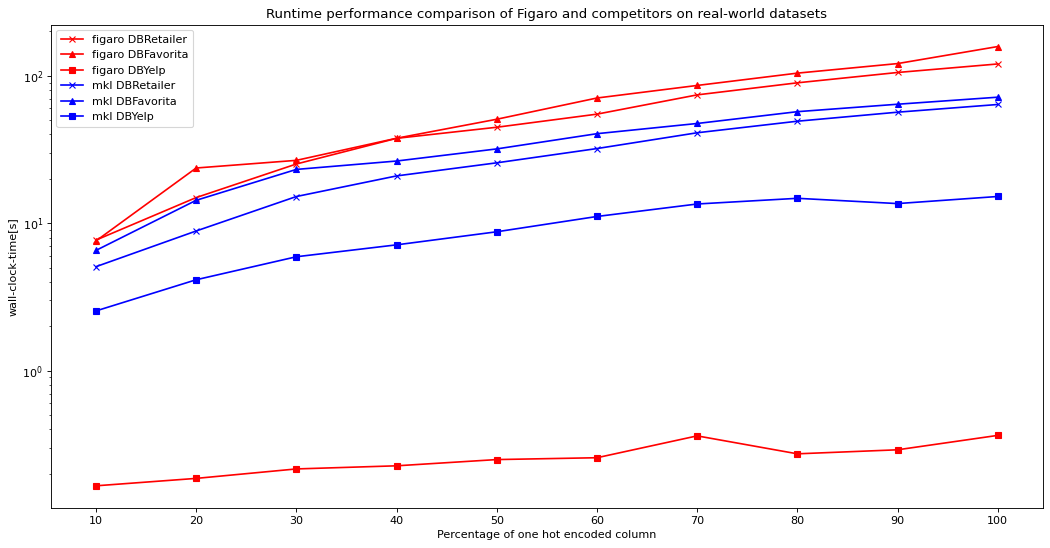

In [5]:
import matplotlib.pyplot as plt

plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Percentage of one hot encoded column")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")

plt.yscale('log', base=10)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='x', nbins=10)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
exp_colour = {"figaro": "r", "mkl": "b"}

print(df_measurement_exps)
for exp_name in exp_names:
    print(exp_name)
    df_measurement = df_measurement_exps[exp_name]
    for db_name in df_measurement:
        print(df_measurement[db_name])
        plt.plot(df_measurement[db_name], "-" + exp_colour[exp_name] + db_marker[db_name], label="{} {}".format(exp_name, db_name))
plt.legend(loc="upper left")

plt.show()